In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score ,confusion_matrix, roc_auc_score, f1_score


In [2]:
data = pd.read_csv("/home/daniar/Vs_Code/Kuliah/Semester 4/TWS/Projek TWS/data/data_klasifikasi_cuaca_kompas.csv")

new_columns = ["TN", "TX", "TAVG", "RR", "RH_AVG","SS","DDD_CAR", "LABEL"]
data.columns = new_columns

data

,TN,TX,TAVG,RR,RH_AVG,SS,DDD_CAR,LABEL
0,21.9,31.5,27.0,0.8,65.5,0.5,NW,cerah
1,24.3,30.7,28.3,0.1,84.8,8.7,NNE,cerah
2,24.2,27.1,25.4,3.7,70.6,3.9,SSW,cerah
3,21.5,28.0,24.5,1.7,64.9,3.3,SE,hujan
4,22.3,30.4,26.4,0.2,80.7,5.5,WSW,cerah
...,...,...,...,...,...,...,...,...
195,21.1,22.8,20.9,5.3,83.8,2.5,NE,hujan
196,24.8,27.2,26.3,5.1,74.7,3.6,ESE,hujan
197,21.4,31.3,26.3,11.2,74.3,2.1,NW,hujan
198,21.1,22.4,21.1,3.2,90.3,8.7,NNW,hujan


In [3]:
data["LABEL"] = data["LABEL"].map({"hujan" : 0, "cerah" : 1})

In [4]:
compass_to_degrees = {
    "N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5,
    "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
    "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5,
    "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5
}

def direction_to_sin_cos(direction):
    if pd.isna(direction) or direction not in compass_to_degrees:
        return 0.0, 0.0
    degree = compass_to_degrees[direction]
    rad = np.deg2rad(degree)
    return np.sin(rad), np.cos(rad)

data['WindGustDir_sin'], data['WindGustDir_cos'] = zip(*data['DDD_CAR'].map(direction_to_sin_cos))
data.drop(columns=['DDD_CAR'], inplace=True)
data

,TN,TX,TAVG,RR,RH_AVG,SS,LABEL,WindGustDir_sin,WindGustDir_cos
0,21.9,31.5,27.0,0.8,65.5,0.5,1,-0.707107,7.071068e-01
1,24.3,30.7,28.3,0.1,84.8,8.7,1,0.382683,9.238795e-01
2,24.2,27.1,25.4,3.7,70.6,3.9,1,-0.382683,-9.238795e-01
3,21.5,28.0,24.5,1.7,64.9,3.3,0,0.707107,-7.071068e-01
4,22.3,30.4,26.4,0.2,80.7,5.5,1,-0.923880,-3.826834e-01
...,...,...,...,...,...,...,...,...,...
195,21.1,22.8,20.9,5.3,83.8,2.5,0,0.707107,7.071068e-01
196,24.8,27.2,26.3,5.1,74.7,3.6,0,0.923880,-3.826834e-01
197,21.4,31.3,26.3,11.2,74.3,2.1,0,-0.707107,7.071068e-01
198,21.1,22.4,21.1,3.2,90.3,8.7,0,-0.382683,9.238795e-01


In [5]:
X = data.drop(columns=["LABEL"])
y = data["LABEL"]

# Bagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled)

[[-1.52297754 -1.60328239 -1.51679559 -0.88955283 -0.67519933 -1.40983933
   1.34870326  0.6325843 ]
 [ 0.06381673  0.09535535 -0.0632975  -1.08316771 -0.15519022 -1.33528164
  -0.5888095   1.41415613]
 [-0.76407594  0.09535535 -0.11018453 -0.80350177  0.19481591 -1.40983933
  -0.02132515  1.52408599]
 [ 0.68473622  0.12623967  0.49934693  0.16457265  1.14483255 -0.8133778
   1.46158292  0.07992957]
 [ 0.75372728 -0.61498407  0.21802471  0.33667477 -0.17519057  1.42335291
  -0.5888095  -1.25429699]
 [ 0.89170939  0.62038883  0.64000803 -0.93257836  1.29483518  0.97600676
   0.5461592  -1.25429699]
 [ 1.37464678  0.21889264  0.45245989 -0.93257836 -1.24520931  0.86417023
  -0.02132515  1.52408599]
 [ 1.37464678  1.97929902  1.85907095  0.33667477 -0.18519074 -0.92521434
   1.34870326  0.6325843 ]
 [ 1.58161994  0.62038883  0.7337821  -0.82501454  1.81484429  1.46063175
  -0.02132515  0.07992957]
 [ 0.06381673  0.86746341  0.82755617  0.20759818  0.61482327  0.97600676
   0.5461592  -1.2

In [6]:
oversampling_methods = {
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=42)
}

custom_threshold = 0.4

blSmote = BorderlineSMOTE(random_state=42)

X_res, y_res = blSmote.fit_resample(X_train_scaled, y_train)
# Train model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_res, y_res)
# Predict probabilities
y_proba = model.predict_proba(X_test_scaled)[:, 1]
# Apply threshold
y_pred_custom = (y_proba >= custom_threshold).astype(int)
y_pred_default = (y_proba >= 0.5).astype(int)

print(f"\n--- Default Threshold (0.5) ---")
print(classification_report(y_test, y_pred_default, digits=2))
print(f"\n--- Custom Threshold ({custom_threshold}) ---")
print(classification_report(y_test, y_pred_custom, digits=2))


--- Default Threshold (0.5) ---
              precision    recall  f1-score   support

           0       0.86      0.89      0.88        28
           1       0.73      0.67      0.70        12

    accuracy                           0.82        40
   macro avg       0.79      0.78      0.79        40
weighted avg       0.82      0.82      0.82        40


--- Custom Threshold (0.4) ---
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        28
           1       0.67      0.83      0.74        12

    accuracy                           0.82        40
   macro avg       0.79      0.83      0.80        40
weighted avg       0.84      0.82      0.83        40



In [7]:
import joblib

joblib.dump(scaler, "/home/daniar/Vs_Code/Kuliah/Semester 4/TWS/Coba coba/my_models/fix_scaler.pkl")
joblib.dump(model, "/home/daniar/Vs_Code/Kuliah/Semester 4/TWS/Coba coba/my_models/fix_model.pkl")

['/home/daniar/Vs_Code/Kuliah/Semester 4/TWS/Coba coba/my_models/fix_model.pkl']

In [8]:
print("ROC AUC:", roc_auc_score(y_test, y_proba))

ROC AUC: 0.9017857142857143


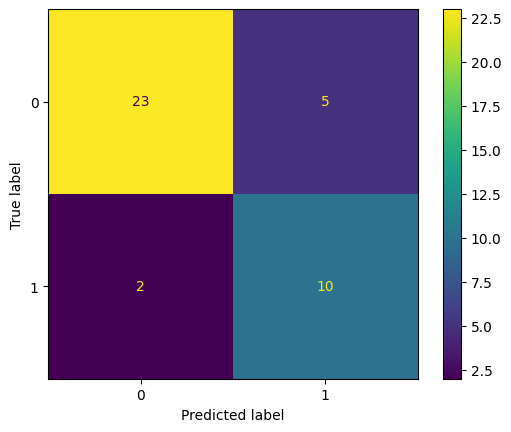

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_custom)

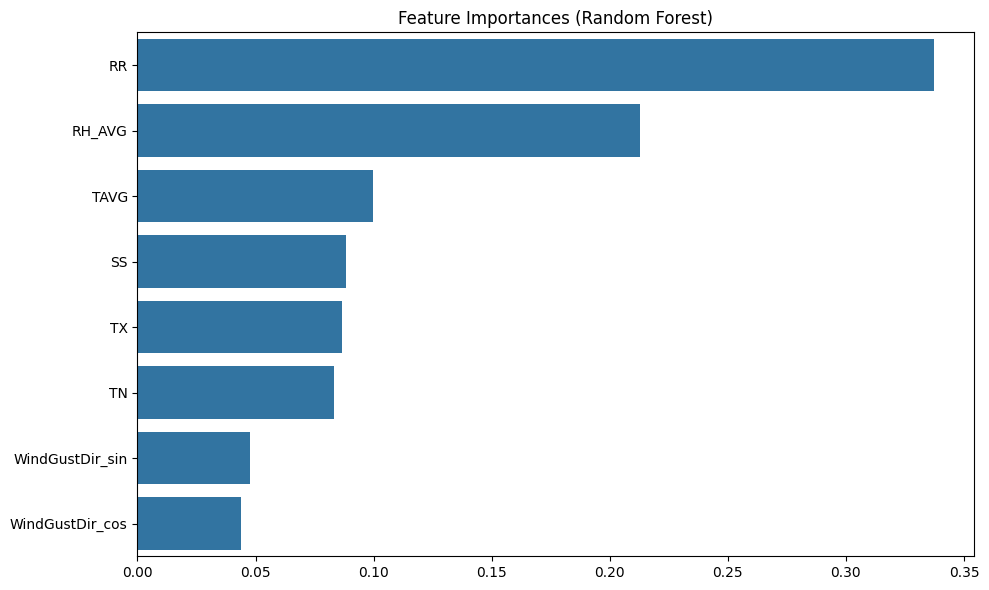

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

### Pecobaan

In [11]:
# oversampling_methods = {
#     "SMOTE": SMOTE(random_state=42),
#     "ADASYN": ADASYN(random_state=42),
#     "BorderlineSMOTE": BorderlineSMOTE(random_state=42)
# }

# custom_threshold = 0.4

# for name, sampler in oversampling_methods.items():
#     # blSmote = BorderlineSMOTE(random_state=42)

#     X_res, y_res = sampler.fit_resample(X_train_scaled, y_train)
#     # Train model
#     model = RandomForestClassifier(class_weight='balanced', random_state=42)
#     model.fit(X_res, y_res)
#     # Predict probabilities
#     y_proba = model.predict_proba(X_test_scaled)[:, 1]
#     # Apply threshold
#     y_pred_custom = (y_proba >= custom_threshold).astype(int)
#     y_pred_default = (y_proba >= 0.5).astype(int)

#     print(f"\n--- Default Threshold (0.5) ---")
#     print(classification_report(y_test, y_pred_default, digits=2))
#     print(f"\n--- Custom Threshold ({custom_threshold}) ---")
#     print(classification_report(y_test, y_pred_custom, digits=2))

In [12]:
# custom_threshold = 0.4

# blSmote = BorderlineSMOTE(random_state=42)

# X_res, y_res = blSmote.fit_resample(X_train_scaled, y_train)
# # Train model

# param_dist = {
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [None, 10, 20, 30, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False],
#     'max_features': ['sqrt', 'log2', None]
# }

# base_model = RandomForestClassifier(class_weight='balanced', random_state=42)

In [13]:
# random_search = RandomizedSearchCV(
#     estimator=base_model,
#     param_distributions=param_dist,
#     n_iter=50,
#     cv=5,
#     verbose=1,
#     n_jobs=-1,
#     random_state=42,
#     scoring='f1'
# )

# random_search.fit(X_res, y_res)

# # === Evaluasi Model Terbaik ===
# best_model = random_search.best_estimator_


In [14]:
# custom_threshold = 0.4
# y_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

# y_pred_default = (y_proba_best >= 0.5).astype(int)
# y_pred_custom = (y_proba_best >= custom_threshold).astype(int)


In [15]:
# print("\n=== Best Parameters ===")
# print(random_search.best_params_)

In [16]:
# print("\n--- Default Threshold (0.5) ---")
# print(classification_report(y_test, y_pred_default, digits=2))

In [17]:
# print(f"\n--- Custom Threshold ({custom_threshold}) ---")
# print(classification_report(y_test, y_pred_custom, digits=2))